In [114]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [115]:
RUTA_BASE = r"C:/Users/brent/Downloads/recaudacion"   # carpeta que contiene 2020, 2021, ...
ANIOS = range(2020, 2026)

MAPA_MESES = {
    "enero": 1,
    "febrero": 2,
    "marzo": 3,
    "abril": 4,
    "mayo": 5,
    "junio": 6,
    "julio": 7,
    "agosto": 8,
    "septiembre": 9,
    "octubre": 10,
    "noviembre": 11,
    "diciembre": 12
}

In [118]:
# Armado de Pipelines
#Función: procesar un año completo (nivel mensual)
def procesar_recaudacion_por_anio(ruta_anio, anio):
    dfs = []

    for archivo in os.listdir(ruta_anio):
        print(f"  leyendo: {archivo}")

        # aceptar xls / xlsx / xlsm
        if not archivo.lower().endswith((".xls", ".xlsx", ".xlsm")):
            print("   ↪ ignorado (no es Excel)")
            continue

        path = os.path.join(ruta_anio, archivo)
        nombre_mes = archivo.replace(".xlsx", "").replace(".xls", "").split("_")[-1].lower()

        try:
            # lectura robusta (sin skiprows fijo)
            df = pd.read_excel(path, sheet_name=0)

            # eliminar filas totalmente vacías
            df = df.dropna(how="all").reset_index(drop=True)

            # validación mínima de estructura
            if df.empty or df.shape[1] < 2:
                print("   ⚠️ ignorado (estructura inválida)")
                continue

            print(f"   filas leídas: {df.shape}")

            # normalizar columnas
            df.columns = (
                df.columns.astype(str)
                .str.strip()
                .str.lower()
            )

            # detectar columna de impuesto
            posibles_conceptos = [
                c for c in df.columns
                if "concepto" in c or "impuesto" in c or "detalle" in c
            ]
            col_impuesto = posibles_conceptos[0] if posibles_conceptos else df.columns[0]

            # columna de recaudación (segunda)
            col_recaudacion = df.columns[1]

            df = df[[col_impuesto, col_recaudacion]]
            df.columns = ["impuesto", "recaudacion"]

            # limpieza
            df = df.dropna(subset=["impuesto"])
            df["recaudacion"] = pd.to_numeric(df["recaudacion"], errors="coerce").fillna(0)

            # metadatos
            df["anio"] = anio
            df["mes"] = MAPA_MESES.get(nombre_mes)
            df["mes_nombre"] = nombre_mes

            dfs.append(df)

        except Exception as e:
            print(f"   ❌ error al procesar {archivo}: {e}")

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)

In [120]:
#Función: procesar todos los años (2020–2025)
def procesar_recaudacion_historica(ruta_base, anios):
    dfs = []

    for anio in anios:
        ruta_anio = os.path.join(ruta_base, str(anio))
        print(f"\nProcesando: {ruta_anio}")

        if not os.path.isdir(ruta_anio):
            print("  ❌ carpeta no encontrada")
            continue

        df_anio = procesar_recaudacion_por_anio(ruta_anio, anio)
        print(f"  filas consolidadas año {anio}: {df_anio.shape}")

        if not df_anio.empty:
            dfs.append(df_anio)

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


In [99]:
#Ejecución del pipeline
df_base = procesar_recaudacion_historica(RUTA_BASE, ANIOS)

print("\nRESULTADO FINAL")
print(df_base.shape)
df_base.head()


Procesando: C:/Users/brent/Downloads/recaudacion\2020
  leyendo: 2020_abril.xls
   filas leídas: (52, 8)
  leyendo: 2020_agosto.xlsx
   filas leídas: (53, 8)
  leyendo: 2020_diciembre.xls
   filas leídas: (52, 8)
  leyendo: 2020_enero.xls
   filas leídas: (52, 6)
  leyendo: 2020_febrero.xls
   filas leídas: (52, 8)
  leyendo: 2020_julio.xlsx
   filas leídas: (53, 8)
  leyendo: 2020_junio.xls
   filas leídas: (54, 8)
  leyendo: 2020_marzo.xls
   filas leídas: (52, 8)
  leyendo: 2020_mayo.xlsx
   filas leídas: (55, 8)
  leyendo: 2020_noviembre.xls
   filas leídas: (53, 8)
  leyendo: 2020_octubre.xlsx
   filas leídas: (53, 8)
  leyendo: 2020_septiembre.xlsx
   filas leídas: (53, 8)
  filas consolidadas año 2020: (592, 5)

Procesando: C:/Users/brent/Downloads/recaudacion\2021
  leyendo: 2021_abril.xls
   filas leídas: (54, 8)
  leyendo: 2021_agosto.xls
   filas leídas: (54, 8)
  leyendo: 2021_diciembre.xls
   filas leídas: (54, 8)
  leyendo: 2021_enero.xlsx
   filas leídas: (52, 6)
  leye

,impuesto,recaudacion,anio,mes,mes_nombre
0,DIRECCION NACION...,0.000000,2020,4,abril
1,RECAUDACION TRIBUTARIA. ABRIL DE 2020. (1),0.000000,2020,4,abril
2,en millones de pesos,0.000000,2020,4,abril
3,Concepto,0.000000,2020,4,abril
4,Ganancias,73483.324537,2020,4,abril


In [122]:
df_base.shape
df_base.head()
df_base.sample(10)

,impuesto,recaudacion,anio,mes,mes_nombre
1439,RECAUDACION TRIBUTARIA. JULIO DE 2022. (1),0.000000e+00,2022,7,julio
216,Bienes Personales,5.185310e+03,2020,2,febrero
374,Total DGI-DGA,3.237075e+05,2020,3,marzo
219,Otros impuestos (3),4.594996e+03,2020,2,febrero
2725,Ganancias DGA,2.241620e+05,2024,11,noviembre
694,Concepto,0.000000e+00,2021,12,diciembre
1412,Otros SIPA (-),4.952873e+03,2022,2,febrero
268,Otros impuestos (3),4.411224e+03,2020,7,julio
1818,Provincias (6),1.370998e+06,2023,8,agosto
3106,el impuesto sobre Pasajes Aéreos y ...,0.000000e+00,2025,2,febrero


In [124]:
ruta_salida = "recaudacion_historica_2020_2025.csv"

df_base.to_csv(
    ruta_salida,
    index=False,
    encoding="utf-8-sig"
)

print(f"Archivo exportado correctamente en: {ruta_salida}")

Archivo exportado correctamente en: recaudacion_historica_2020_2025.csv


📊 Análisis y Gráficos Recomendados (Matplotlib)
1️⃣ Evolución de la recaudación total en el tiempo (mensual)
🎯 Objetivo

Ver tendencia, ciclos y shocks (pandemia, inflación, cambios fiscales).

📈 Gráfico

Línea (time series)

🧠 Qué muestra bien

Tendencia general

Estacionalidad

Caídas o saltos abruptos

🧪 Dataset

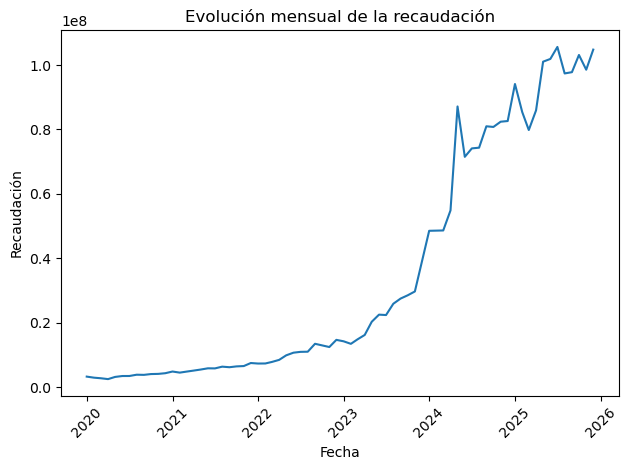

In [129]:
df_mensual = (
    df_base
    .groupby(["anio", "mes"])["recaudacion"]
    .sum()
    .reset_index()
)

df_mensual["fecha"] = pd.to_datetime(
    df_mensual["anio"].astype(str) + "-" + df_mensual["mes"].astype(str)
)

df_mensual = df_mensual.sort_values("fecha")

plt.figure()
plt.plot(df_mensual["fecha"], df_mensual["recaudacion"])

plt.title("Evolución mensual de la recaudación")
plt.xlabel("Fecha")
plt.ylabel("Recaudación")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


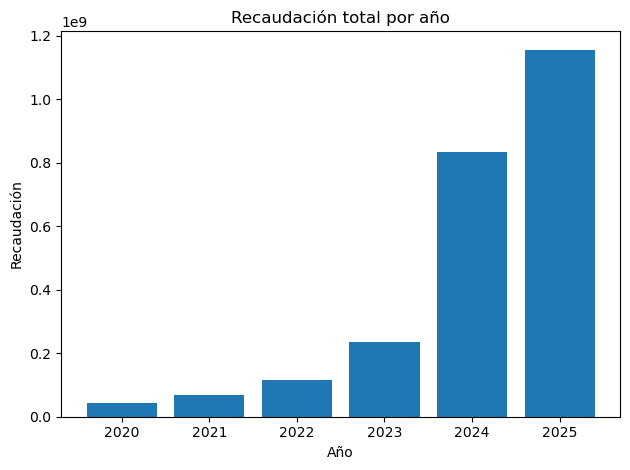

In [131]:
#Recaudación anual total

#👉 Perfecto para comparar crecimiento entre años.

df_anual = (
    df_base
    .groupby("anio")["recaudacion"]
    .sum()
    .reset_index()
)

plt.figure()
plt.bar(df_anual["anio"], df_anual["recaudacion"])

plt.title("Recaudación total por año")
plt.xlabel("Año")
plt.ylabel("Recaudación")

plt.tight_layout()
plt.show()

In [133]:
#3. Comparación interanual por mes (YoY)

#👉 Muestra cómo se comporta cada año contra los otros.df_yoy = (
 
df_base
    .groupby(["anio", "mes"])["recaudacion"]
    .sum()
    .reset_index()
)

plt.figure()

for anio in df_yoy["anio"].unique():
    datos = df_yoy[df_yoy["anio"] == anio]
    plt.plot(datos["mes"], datos["recaudacion"], label=str(anio))

plt.title("Comparación interanual mensual")
plt.xlabel("Mes")
plt.ylabel("Recaudación")
plt.legend()

plt.tight_layout()
plt.show()

IndentationError: unexpected indent (2321210587.py, line 6)

2️⃣ Comparación interanual (YoY) por mes
🎯 Objetivo

Comparar mismo mes en distintos años.

📈 Gráfico

Líneas múltiples (una por año)

🧠 Qué responde

¿Enero 2024 fue mejor que Enero 2023?

🧪 Dataset

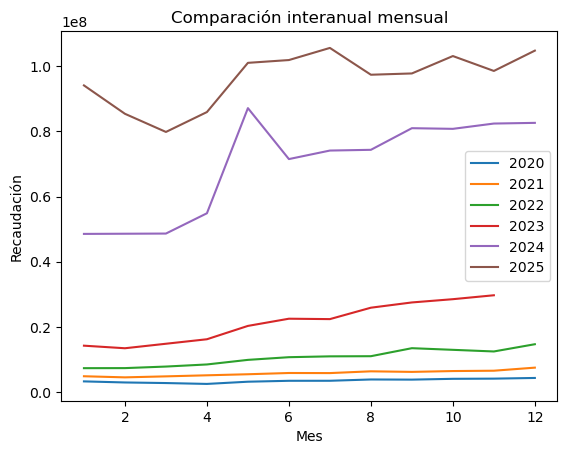

In [135]:
df_mes_yoy = (
    df_base
    .groupby(["anio", "mes"])["recaudacion"]
    .sum()
    .reset_index()
)

plt.figure()

for anio in df_mes_yoy["anio"].unique():
    datos = df_mes_yoy[df_mes_yoy["anio"] == anio]
    plt.plot(datos["mes"], datos["recaudacion"], label=str(anio))

plt.title("Comparación interanual mensual")
plt.xlabel("Mes")
plt.ylabel("Recaudación")
plt.legend()

plt.show()

3️⃣ Recaudación anual total
🎯 Objetivo

Ver crecimiento o caída estructural.

📊 Gráfico

Barras

🧠 Ideal para

Comparar años

Presentar a stakeholders

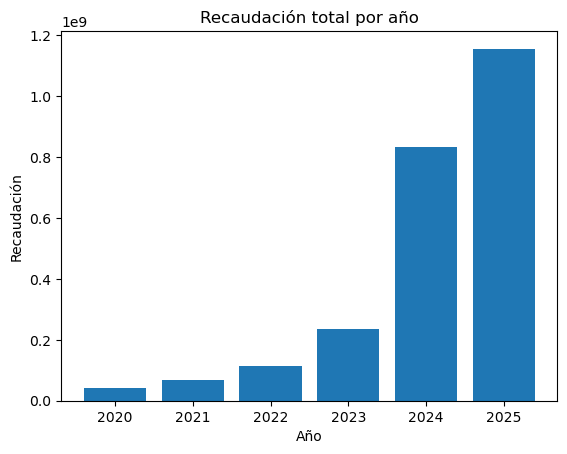

In [137]:
df_anual = (
    df_base
    .groupby("anio")["recaudacion"]
    .sum()
    .reset_index()
)

plt.figure()

plt.bar(df_anual["anio"], df_anual["recaudacion"])

plt.title("Recaudación total por año")
plt.xlabel("Año")
plt.ylabel("Recaudación")

plt.show()

4️⃣ Top impuestos por recaudación (anual)
🎯 Objetivo

Identificar qué impuestos explican la mayor parte de la recaudación.

📊 Gráfico

Barras horizontales

🧠 Insight típico

Principio de Pareto (80/20).

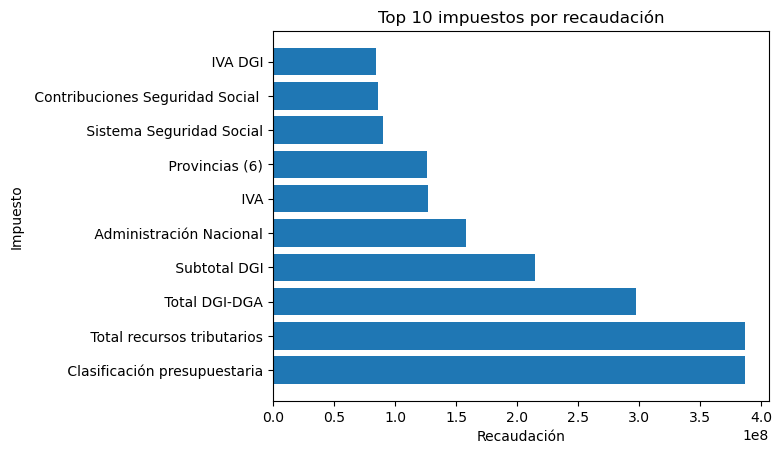

In [139]:
df_top_impuestos = (
    df_base
    .groupby("impuesto")["recaudacion"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()

plt.barh(df_top_impuestos.index, df_top_impuestos.values)

plt.title("Top 10 impuestos por recaudación")
plt.xlabel("Recaudación")
plt.ylabel("Impuesto")

plt.show()

5️⃣ Composición de la recaudación por impuesto (stacked)
🎯 Objetivo

Ver cómo cambia la estructura tributaria en el tiempo.

📊 Gráfico

Barras apiladas por año

🧠 Muy bueno para

Análisis estructural

Cambios en la matriz impositiva

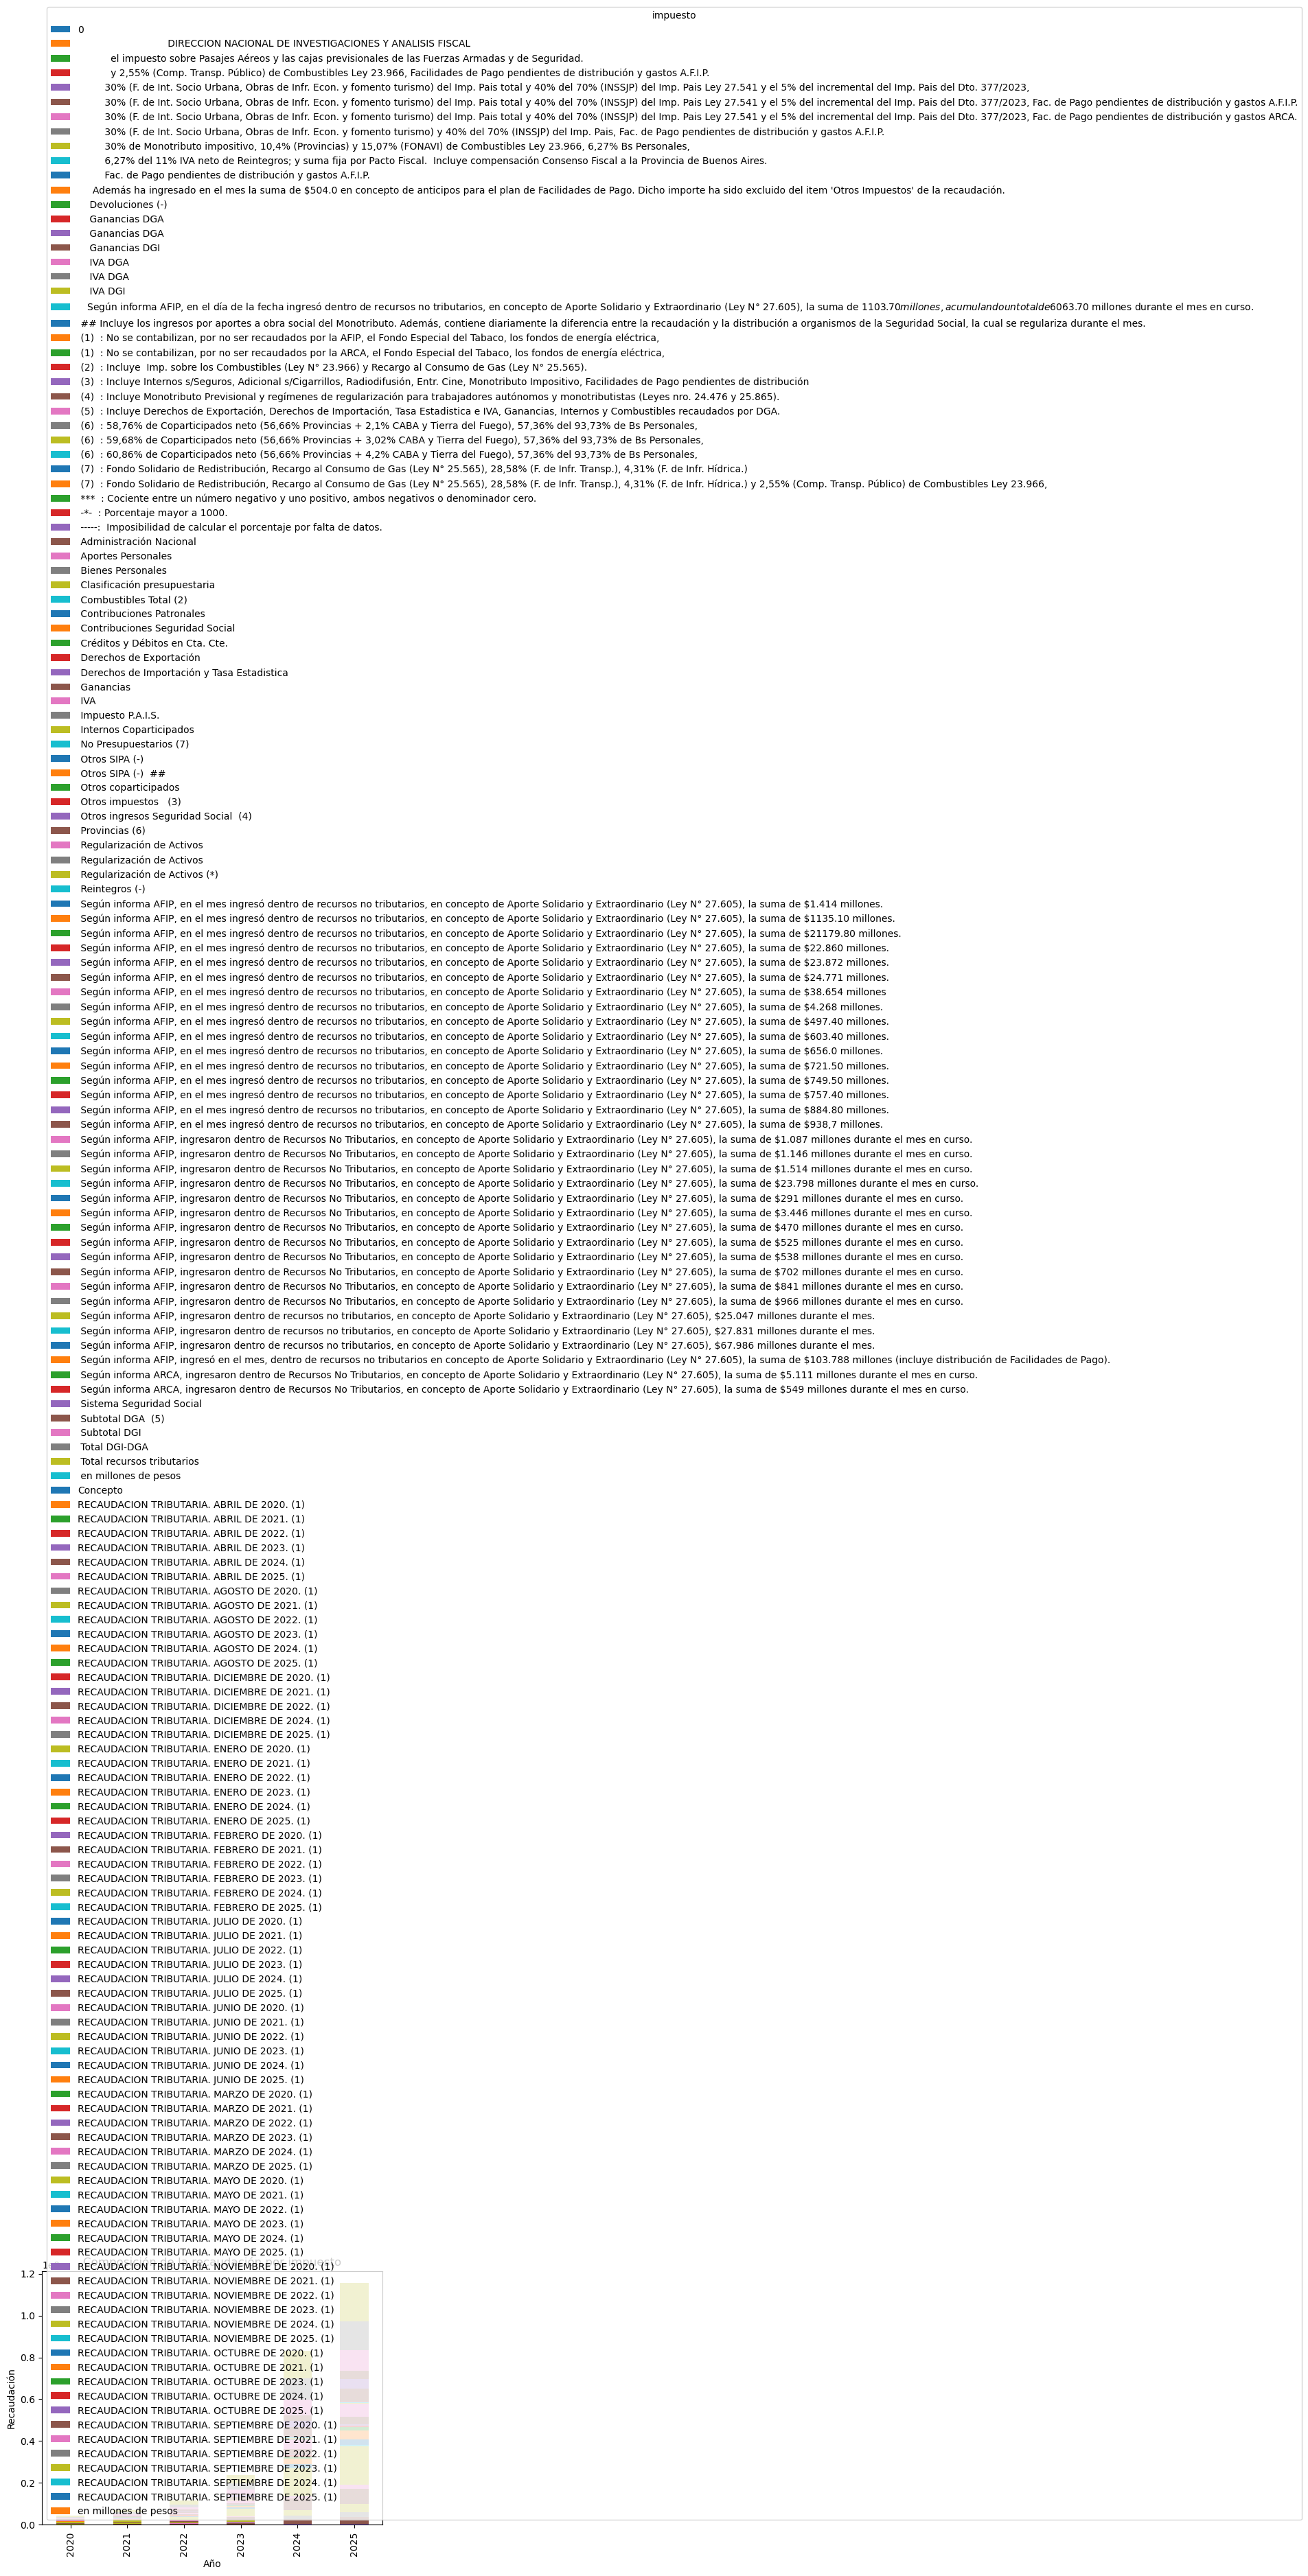

In [141]:
df_stack = (
    df_base
    .groupby(["anio", "impuesto"])["recaudacion"]
    .sum()
    .reset_index()
)

df_pivot = df_stack.pivot(
    index="anio",
    columns="impuesto",
    values="recaudacion"
).fillna(0)

df_pivot.plot(kind="bar", stacked=True)

plt.title("Composición de la recaudación por impuesto")
plt.xlabel("Año")
plt.ylabel("Recaudación")

plt.show()

6️⃣ Estacionalidad mensual (promedio histórico)
🎯 Objetivo

Detectar meses fuertes vs débiles.

📈 Gráfico

Línea o barras

🧠 Insight

¿Qué meses históricamente recaudan más?

In [ ]:
df_estacionalidad = (
    df_base
    .groupby("mes")["recaudacion"]
    .mean()
    .reset_index()
)

7️⃣ Variación porcentual mensual
🎯 Objetivo

Detectar volatilidad y cambios bruscos.

📈 Gráfico

Línea

🧠 Ideal para

Shock económico

Cambios normativos

In [ ]:
df_mensual["variacion_pct"] = (
    df_mensual["recaudacion"].pct_change() * 100
)

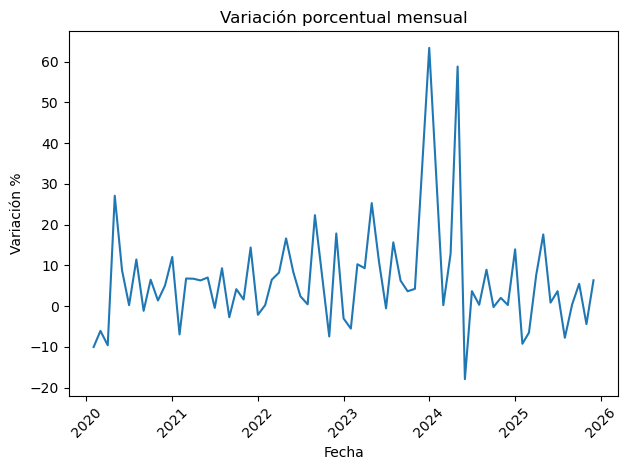

In [143]:
#6. Variación porcentual mensual

#👉 Detecta volatilidad.

df_mensual["variacion_pct"] = (
    df_mensual["recaudacion"].pct_change() * 100
)

plt.figure()
plt.plot(df_mensual["fecha"], df_mensual["variacion_pct"])

plt.title("Variación porcentual mensual")
plt.xlabel("Fecha")
plt.ylabel("Variación %")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

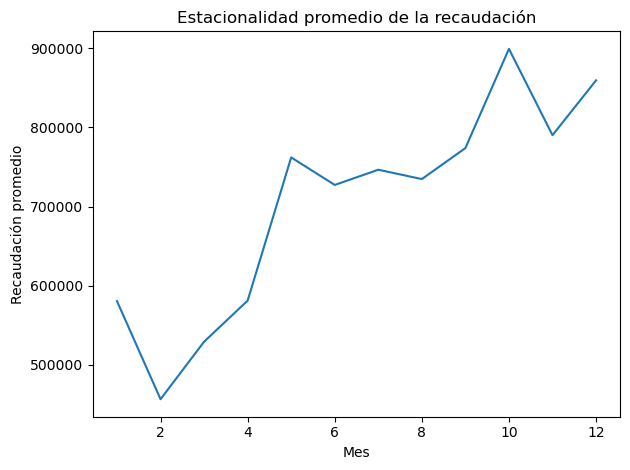

In [145]:
#5. Estacionalidad promedio por mes

#👉 Detecta meses fuertes o débiles.

df_estacionalidad = (
    df_base
    .groupby("mes")["recaudacion"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(df_estacionalidad["mes"], df_estacionalidad["recaudacion"])

plt.title("Estacionalidad promedio de la recaudación")
plt.xlabel("Mes")
plt.ylabel("Recaudación promedio")

plt.tight_layout()
plt.show()

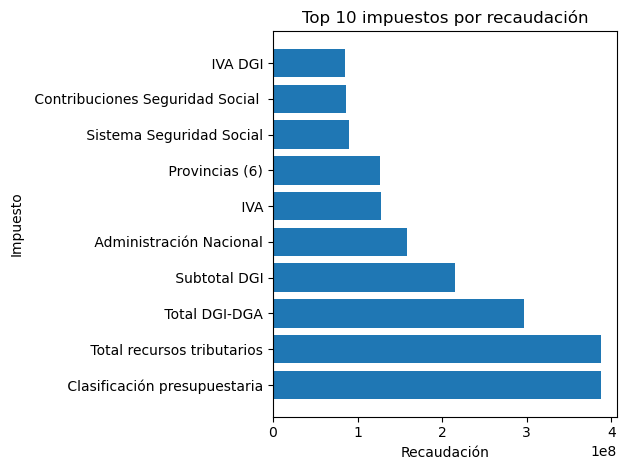

In [147]:
#4. Top 10 impuestos por recaudación

#👉 Identifica qué impuestos pesan más.

df_top = (
    df_base
    .groupby("impuesto")["recaudacion"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
plt.barh(df_top.index, df_top.values)

plt.title("Top 10 impuestos por recaudación")
plt.xlabel("Recaudación")
plt.ylabel("Impuesto")

plt.tight_layout()
plt.show()